# Building a Sentiment Classifier Based on the Tweet Sentiment Extraction Dataset

**Purpose:** Analyze the dataset, vectorize the text data using bag-of-words and TF-IDF methods, compare the results, build a classifier, and perform error analysis..

**Files**

`train.csv` - the training set

`test.csv` - the test set

`sample_submission.csv` - a sample submission file in the correct format


**Columns**

- textID - unique ID for each piece of text
- text - the text of the tweet
- sentiment - the general sentiment of the tweet
- selected_text - [train only] the text that supports the tweet's sentiment


### Loading and Exploring the Dataset

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
train_fname = 'tweet_sentiment_train.csv.zip'
raw_df = pd.read_csv(train_fname)

In [25]:
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### Exploratory Data Analysis

In [27]:
raw_df.sentiment.value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [28]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [29]:
raw_df = raw_df.dropna()

**Now we have no missing values. The data frame consists of 27 thousand rows and 4 columns. There are three classes with a distribution of approximately 2:1:1 with the predominance of the neutral class**

(array([1231., 3338., 4002., 3818., 3175., 2952., 2554., 2182., 2584.,
        1644.]),
 array([  3. ,  16.8,  30.6,  44.4,  58.2,  72. ,  85.8,  99.6, 113.4,
        127.2, 141. ]),
 <BarContainer object of 10 artists>)

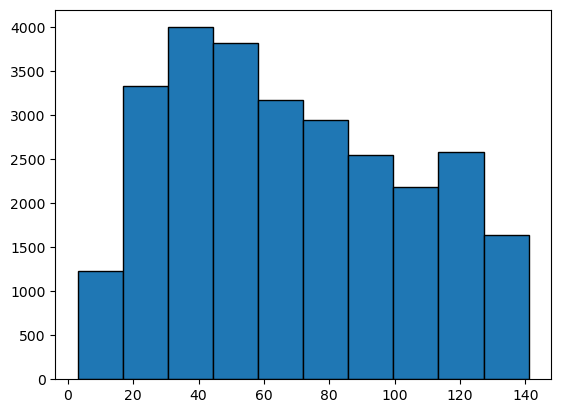

In [31]:
raw_df['symbol_count'] = raw_df['text'].apply(len)

plt.hist(raw_df['symbol_count'], bins=10, edgecolor='black')

**The majority of characters in the comments are between 20 and 90, approximately.**

### Text Data Preprocessing and Vectorization with Bag of Words

We should here to obtain vectors using the bag of words method for the `text` column, after performing text preprocessing. 

The preprocessing includes:

- Tokenization (splitting the text into fragments of 1 word)
- Removing stopwords for the required language
- Stemming words with `SnowballStemmer`
- Setting the number of words in the vocabulary for `sklearn.feature_extraction.text.CountVectorizer`


#### Tokenization (splitting the text into fragments of 1 word)

In [35]:
# pip install nltk

In [36]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [39]:
english_stopwords = stopwords.words('english')

In [40]:
english_stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [41]:
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in english_stopwords]

In [42]:
raw_df['text_tok_stp'] = raw_df['text'].apply(lambda x: remove_stopwords(word_tokenize(x)))

In [43]:
raw_df

,textID,text,selected_text,sentiment,symbol_count,text_tok_stp
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,"[`, responded, ,, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,"[Sooo, SAD, miss, San, Diego, !, !, !]"
2,088c60f138,my boss is bullying me...,bullying me,negative,25,"[boss, bullying, ...]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,"[interview, !, leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,"[Sons, *, *, *, *, ,, `, put, releases, alread..."
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,77,"[wish, could, come, see, u, Denver, husband, l..."
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,122,"[`, wondered, rake, ., client, made, clear, .N..."
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,111,"[Yay, good, ., Enjoy, break, -, probably, need..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,27,"[worth, *, *, *, *, .]"


#### Stemming words with SnowballStemmer

In [45]:
from nltk.stem.snowball import SnowballStemmer

In [46]:
stemmer = SnowballStemmer(language='english')

In [47]:
def stem_words(tokens):
    return [stemmer.stem(word) for word in tokens]

In [48]:
raw_df['text_stem'] = raw_df['text_tok_stp'].apply(lambda x: stem_words(x))

In [49]:
raw_df.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

#### Vectorizer

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
raw_df['text_stem_joined'] = raw_df['text_stem'].apply(lambda x: ' '.join(x))

In [53]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(raw_df['text_stem_joined'])

count_matrix = X.toarray()

feature_names = vectorizer.get_feature_names_out()

### Building the Classifier

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# 1. Encoding Sentiment Labels
label_encoder = LabelEncoder()
raw_df['sentiment_encoded'] = label_encoder.fit_transform(raw_df['sentiment'])

# 2. Splitting into Training and Test Sets
X = raw_df['text_stem_joined'] 
y = raw_df['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Text Vectorization with Bag-of-Words (CountVectorizer)
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# 4. Trying Several Models

# Model 1: Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_bow, y_train)
y_pred_logreg = logreg.predict(X_test_bow)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

# Model 2: Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train_bow, y_train)
y_pred_tree = tree.predict(X_test_bow)
accuracy_tree = accuracy_score(y_test, y_pred_tree)

# Model 3: Gradient Boosting
boost = GradientBoostingClassifier()
boost.fit(X_train_bow, y_train)
y_pred_boost = boost.predict(X_test_bow)
accuracy_boost = accuracy_score(y_test, y_pred_boost)

# 5. Outputting Reports with Metrics for All Models
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_logreg:.4f}\n")

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_tree:.4f}\n")

print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_boost, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_boost:.4f}\n")

# 6. Model Evaluation
best_model = max([("Logistic Regression", accuracy_logreg), 
                  ("Decision Tree", accuracy_tree), 
                  ("Gradient Boosting", accuracy_boost)], key=lambda x: x[1])

print(f"Best model: {best_model[0]} having accuracy of {best_model[1]:.4f}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.60      0.64      1572
     neutral       0.63      0.72      0.67      2236
    positive       0.76      0.72      0.74      1688

    accuracy                           0.68      5496
   macro avg       0.69      0.68      0.68      5496
weighted avg       0.69      0.68      0.68      5496

Accuracy: 0.6843

Decision Tree Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.62      0.63      1572
     neutral       0.65      0.66      0.66      2236
    positive       0.70      0.71      0.71      1688

    accuracy                           0.66      5496
   macro avg       0.66      0.66      0.66      5496
weighted avg       0.66      0.66      0.66      5496

Accuracy: 0.6634

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

    negative       0.79   

### Analysis of Word Influence in the Trained Classifier

- For the Logistic Regression model, we will determine which words (tokens) have the most influence in determining sentiment.



Топ 10 слів для сентименту 'negative':
Top Positive:
sad         2.662491
suck        2.480719
bore        2.405341
sorri       2.254786
hate        2.242279
miss        2.134519
fail        2.065498
shame       2.030803
unfortun    1.970189
stupid      1.962236
Name: negative, dtype: float64

Top Negative:
glad      -2.264426
awesom    -2.240362
love      -2.059358
thank     -1.933347
cute      -1.860034
congrat   -1.817927
welcom    -1.701237
bless     -1.673356
beauti    -1.622388
amaz      -1.608951
Name: negative, dtype: float64

Топ 10 слів для сентименту 'neutral':
Top Positive:
chan       1.510057
nigga      1.302804
parvo      1.295474
hummmmm    1.158473
gent       1.150372
satisfi    1.060297
idol       1.044750
logic      1.039480
jst        1.038291
67hac      1.036433
Name: neutral, dtype: float64

Top Negative:
piss        -1.459270
congratul   -1.453616
delici      -1.355856
thrill      -1.351993
4am         -1.329930
proud       -1.309170
excel       -1.255930
healthi

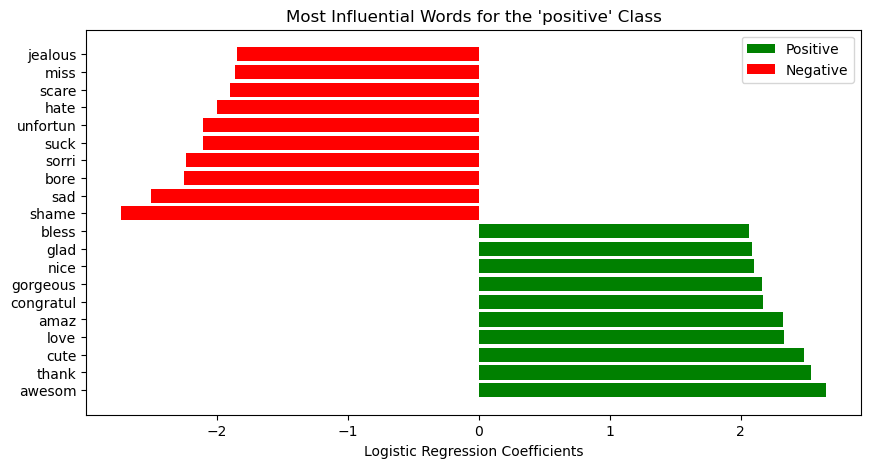

In [57]:
import numpy as np

coefficients = logreg.coef_ 
feature_names = vectorizer.get_feature_names_out()

importance_df = pd.DataFrame(coefficients.T, index=feature_names, columns=label_encoder.classes_)

for sentiment in label_encoder.classes_:
    print(f"\nТоп 10 слів для сентименту '{sentiment}':")
    
    top_positive = importance_df[sentiment].nlargest(10)
    top_negative = importance_df[sentiment].nsmallest(10)
    
    print("Top Positive:")
    print(top_positive)
    
    print("\nTop Negative:")
    print(top_negative)
    
top_words_positive = importance_df['positive'].nlargest(10)
top_words_negative = importance_df['positive'].nsmallest(10)

plt.figure(figsize=(10, 5))

plt.barh(top_words_positive.index, top_words_positive.values, color='green', label='Positive')
plt.barh(top_words_negative.index, top_words_negative.values, color='red', label='Negative')

plt.xlabel('Logistic Regression Coefficients')
plt.title("Most Influential Words for the 'positive' Class")
plt.legend()
plt.show()

### Text Vectorization Using TF-IDF. Training the Classifier, Accuracy Analysis, and Word Influence.


TF-IDF Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.57      0.63      1572
     neutral       0.62      0.74      0.68      2236
    positive       0.76      0.70      0.73      1688

    accuracy                           0.68      5496
   macro avg       0.70      0.67      0.68      5496
weighted avg       0.69      0.68      0.68      5496

Accuracy: 0.6818

Bag-of-Words Accuracy: 0.6843
TF-IDF Accuracy: 0.6818

Top 10 words for the 'negative' sentiment (TF-IDF):
Top Positive Influence:
sad       5.652523
miss      5.413508
hate      4.609451
suck      4.608539
sorri     4.549018
bore      4.094784
fail      3.702645
stupid    3.493853
hurt      3.452273
poor      3.428780
Name: negative, dtype: float64

Top Negative Influence:
love     -4.951704
thank    -4.079850
awesom   -3.435801
hope     -3.435366
great    -2.974338
nice     -2.819450
glad     -2.699791
better   -2.521691
cute     -2.301202
yay

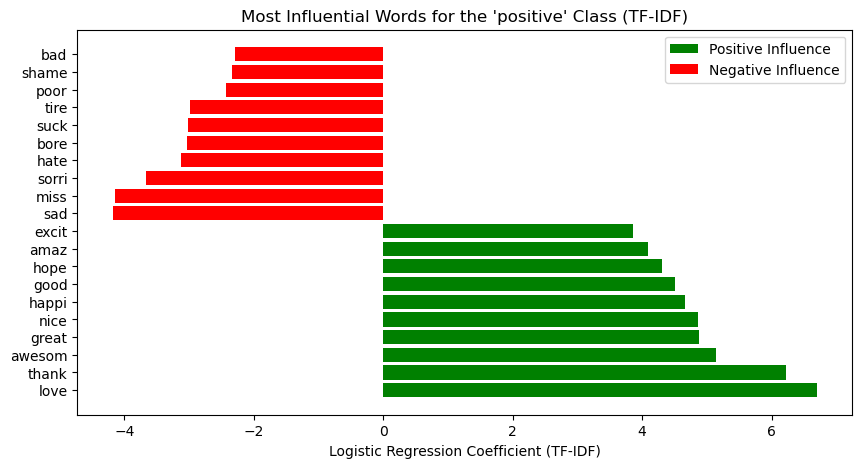

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

logreg_tfidf = LogisticRegression(max_iter=1000)
logreg_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

print("TF-IDF Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_tfidf, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_tfidf:.4f}\n")

print(f"Bag-of-Words Accuracy: {accuracy_logreg:.4f}")
print(f"TF-IDF Accuracy: {accuracy_tfidf:.4f}")

tfidf_coefficients = logreg_tfidf.coef_
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_importance_df = pd.DataFrame(tfidf_coefficients.T, index=tfidf_feature_names, columns=label_encoder.classes_)

for sentiment in label_encoder.classes_:
    print(f"\nTop 10 words for the '{sentiment}' sentiment (TF-IDF):")
    top_positive_tfidf = tfidf_importance_df[sentiment].nlargest(10)
    top_negative_tfidf = tfidf_importance_df[sentiment].nsmallest(10)

    print("Top Positive Influence:")
    print(top_positive_tfidf)

    print("\nTop Negative Influence:")
    print(top_negative_tfidf)

top_words_positive_tfidf = tfidf_importance_df['positive'].nlargest(10)
top_words_negative_tfidf = tfidf_importance_df['positive'].nsmallest(10)

plt.figure(figsize=(10, 5))
plt.barh(top_words_positive_tfidf.index, top_words_positive_tfidf.values, color='green', label='Positive Influence')
plt.barh(top_words_negative_tfidf.index, top_words_negative_tfidf.values, color='red', label='Negative Influence')

plt.xlabel('Logistic Regression Coefficient (TF-IDF)')
plt.title("Most Influential Words for the 'positive' Class (TF-IDF)")
plt.legend()
plt.show()


### Error Analysis of Classification with TF-IDF Vectorization

- As observed from the analysis, the classifier makes the most mistakes on the negative class when using TF-IDF vectorization.

### Recommendations to Improve Classification Performance:

1. **Experiment with Different Feature Engineering Techniques:**
   - It could be beneficial to try n-grams (bigrams or trigrams) instead of using only unigrams for TF-IDF vectorization. This approach might help capture more context and relationships between words, improving the model's ability to classify sentiment accurately.

2. **Address Class Imbalance:**
   - It is possible to improve performance by addressing potential class imbalance, especially for the negative class. Techniques like oversampling (e.g., SMOTE), undersampling, or adjusting class weights could help the classifier better learn the negative sentiment.

3. **Explore More Advanced Classification Models:**
   - It could be valuable to experiment with more advanced classification models such as Random Forests, XGBoost, or Support Vector Machines (SVMs). These models may handle non-linearities better and offer better generalization, potentially improving performance, especially for the negative class.